In [66]:
import scipy.interpolate
import pandas as pd
from datetime import datetime
import numpy as np
from numpy import linalg as LA
import tvm


## Retrieving Data and Chosen Bonds:

Based on collected data over the past 10 trading days from 30th January 2023, these are the respective bond data required:

In [67]:
CURRENT_DATE = datetime(2023,1,30)

def calculate_time_difference(date_1, date_2):
    return float(abs((date_2 - date_1).days) / 365.25)


In [40]:
def clean_df(df):
    coupon = []
    df['maturity_date'] = pd.to_datetime(df['maturity_date'])
    
    for i in range(df.shape[0]):
        coupon.append(float(df['coupon'][i].split('%')[0]))
    
    # Data Cleaning:
    df['coupon'] = coupon
    df[['bid','ask']] = df[['bid','ask']].replace('-','NaN').astype(float)
    df[['coupon']] = df[['coupon']].astype(float)
    df['close0'] = (df['bid']+df['ask'])/2
    df = df.drop(columns=['bid','ask'])
    df = df.reindex(columns=['maturity_date', 'bond_yield', 'coupon', 'close0'])
    return df

def merge_dataframes(f):
    df = f[0]
    n = 10
    for i in range(1,n):
        extracted_col = f[i]['close0']
        df['day_' + str(i)] = extracted_col
    
    df.rename(columns={'close0': 'day_0', 'bond_yield': 'yield'}, inplace=True)
    # add ttm
    time_to_maturities = []
    for i in range(df.shape[0]):
        date_1 = CURRENT_DATE
        maturity_date = df['maturity_date'][i]
        
        time_to_maturity_year_fraction = calculate_time_difference(date_1, maturity_date)
        time_to_maturities.append(time_to_maturity_year_fraction)
    df['time_to_maturity'] = time_to_maturities
    return df

In [41]:

bond_dates = ["16Jan", "17Jan", "18Jan", "19Jan", "20Jan", "23Jan", "24Jan", "25Jan", "26Jan", "27Jan"]
FOLDER_PATH = "assignment1_bond_data/"

def retrieve_bond_data(bond_dates):
    res = []
    for date in bond_dates:
        file_path = FOLDER_PATH + date + '.json'
        
        # Extract dataframe from JSON file
        read_file = pd.read_json(file_path)
        df = read_file.set_index(['name']).sort_values(['maturity_date'], ascending=[True])
        
        # Clean dataframe
        cleaned_df = clean_df(df)
        res.append(cleaned_df)
        
    
      
    return merge_dataframes(res).reset_index()
    



df = retrieve_bond_data(bond_dates)
df

,name,maturity_date,yield,coupon,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,time_to_maturity
0,CAN 0.25 Feb 23,2023-02-01,-,0.250,99.835,99.845,99.865,99.875,99.915,99.915,99.925,99.935,99.945,99.985,0.005476
1,CAN 1.75 Mar 23,2023-03-01,4.30%,1.750,99.705,99.715,99.710,99.725,99.745,99.745,99.755,99.765,99.775,99.785,0.082136
2,CAN 0.25 May 23,2023-05-01,4.47%,0.250,100.330,100.330,98.855,100.360,98.900,100.390,98.920,100.420,98.960,100.460,0.249144
3,CAN 1.50 Jun 23,2023-06-01,4.52%,1.500,98.920,98.930,98.935,98.950,98.965,98.960,98.970,98.980,99.010,99.010,0.334018
4,CAN 8.00 Jun 23,2023-06-01,4.46%,8.000,101.305,101.300,101.285,101.280,101.240,101.220,101.210,101.210,101.220,101.165,0.334018
5,CAN 0.25 Aug 23,2023-08-01,4.49%,0.250,97.785,97.775,97.795,97.825,97.845,97.855,97.845,97.875,97.905,97.905,0.501027
6,CAN 0.50 Nov 23,2023-11-01,4.45%,0.500,98.440,98.450,98.450,98.540,98.540,98.525,98.530,98.545,98.570,98.565,0.752909
7,CAN 0.75 Feb 24,2024-02-01,4.31%,0.750,96.435,96.455,96.450,96.465,96.465,96.385,96.385,96.405,96.475,96.470,1.004791
8,CAN 2.25 Mar 24,2024-03-01,4.19%,2.250,97.915,97.925,97.895,97.945,97.925,97.865,97.865,97.870,97.940,97.925,1.084189
9,CAN 0.25 Apr 24,2024-04-01,4.18%,0.250,95.460,95.495,95.500,95.535,95.545,95.515,95.525,95.545,95.615,95.625,1.169062


## 10 Chosen Bonds:

Below are the following 10 bonds chosen from the list of bonds retrieved based on their time to maturity and credit rating.

In [42]:
# Picking Bond based on maturity dates:
chosen_bond_indexes = [0,3,6,11,15,19,21,23, 25, 27]
df = df.loc[chosen_bond_indexes]
df

,name,maturity_date,yield,coupon,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,time_to_maturity
0,CAN 0.25 Feb 23,2023-02-01,-,0.25,99.835,99.845,99.865,99.875,99.915,99.915,99.925,99.935,99.945,99.985,0.005476
3,CAN 1.50 Jun 23,2023-06-01,4.52%,1.50,98.920,98.930,98.935,98.950,98.965,98.960,98.970,98.980,99.010,99.010,0.334018
6,CAN 0.50 Nov 23,2023-11-01,4.45%,0.50,98.440,98.450,98.450,98.540,98.540,98.525,98.530,98.545,98.570,98.565,0.752909
11,CAN 2.50 Jun 24,2024-06-01,3.99%,2.50,98.035,98.090,98.105,98.160,98.130,98.070,98.015,98.010,98.085,98.075,1.336071
15,CAN 3.00 Nov 24,2024-11-01,3.77%,3.00,98.675,98.780,98.840,98.920,98.870,98.750,98.700,98.675,98.795,98.780,1.754962
19,CAN 2.25 Jun 25,2025-06-01,3.47%,2.25,97.250,97.460,97.510,97.700,97.680,97.510,97.420,97.380,97.570,97.580,2.335387
21,CAN 0.50 Sep 25,2025-09-01,3.51%,0.50,92.545,92.760,92.810,93.040,93.080,92.890,92.810,92.785,93.005,93.015,2.587269
23,CAN 0.25 Mar 26,2026-03-01,3.36%,0.25,90.880,91.105,91.240,91.415,91.530,91.315,91.195,91.195,91.455,91.460,3.082820
25,CAN 1.00 Sep 26,2026-09-01,3.19%,1.00,92.535,92.735,92.885,93.335,93.275,93.035,92.935,92.935,93.165,93.055,3.586585
27,CAN 1.00 Jun 27,2027-06-01,2.93%,1.00,92.145,92.300,92.415,92.845,92.850,92.400,92.370,92.370,92.595,92.525,4.334018


# Calculation of YTMs:

Generate YTMs for all 10 ten days, for all 10 chosen bonds

In [43]:
PRICE_DAY_HEADER_PREFIX = "day_"
TOTAL_DAYS = 10
COUPON_FREQUENCY = 2

def calculate_ytm(ttm, freq, coupon, price):
    return tvm.TVM(n=ttm*freq, pv=-price, pmt=coupon/freq, fv=100).calc_r() * freq

def retrieve_time_to_maturities(dataframe):
    res = []
    for i, bond in dataframe.iterrows():
        res.append(bond['time_to_maturity'])
    
    return res

def generate_ytms_for_all_days(bonds_dataframe, days, coupon_frequency):
    
    # Get list of TR
    result = []
    # Going through all days
    for i in range(days):
        ytm_one_day = []
        
        for j, bond in bonds_dataframe.iterrows():
            price_column_header = PRICE_DAY_HEADER_PREFIX + str(i)
            
            time = bond['time_to_maturity']
            price = bond[price_column_header]
            coupon = bond['coupon']
            
            # Calculate ytm
            ytm = calculate_ytm(time, coupon_frequency, coupon, price)
            ytm_one_day.append(ytm)
        print(ytm_one_day)
        # Add ytm for 1 day generated to the overall list for all 10 tens
        result.append(ytm_one_day)
    return result

# Retrieve the ttms
tr = retrieve_time_to_maturities(df)
# Retrieve yields for all 10 days:
all_ytms = generate_ytms_for_all_days(df, TOTAL_DAYS, COUPON_FREQUENCY)    

[0.32821153996220004, 0.04797972887340461, 0.026058419682044958, 0.04025382028435349, 0.03787496850279268, 0.034863543622490015, 0.03540835488754575, 0.033906308682257795, 0.032206083670608655, 0.029437683597772348]
[0.3070276829996414, 0.047670237915079745, 0.025921663730724784, 0.03982112759059252, 0.037245908188951286, 0.03390432411130018, 0.034490803705788976, 0.033087984269602036, 0.03158459763954294, 0.029036251603543856]
[0.26524050582296205, 0.04751552170017583, 0.025921663730724784, 0.039703178756691, 0.03688683559511719, 0.03367631346601787, 0.034277784706714144, 0.03259811876993877, 0.03111949525285772, 0.028738907067542847]
[0.2446341274237826, 0.0470514900710278, 0.02469189993277885, 0.03927091311861615, 0.03640851300745781, 0.03281118370621829, 0.033299664404527085, 0.03196436302116637, 0.029729361194706715, 0.027630791229074057]
[0.16408655969886182, 0.046587633892702526, 0.02469189993277885, 0.03950665281399687, 0.036707405620912924, 0.032902152434066814, 0.033129852123

In [44]:
tr

[0.0054757015742642025,
 0.33401779603011633,
 0.7529089664613279,
 1.3360711841204653,
 1.754962354551677,
 2.3353867214236823,
 2.5872689938398357,
 3.082819986310746,
 3.586584531143053,
 4.334017796030117]

## Yield Curve Interpolation:

Cubic spline interpolation technique is chosen hee to get yields on dates across the time frame which will be subsequently used in calculating spot rates via bootstrapping method.

In [45]:

def generate_cublic_spline_interpolation(raw_ytms, ttms):
    interpolated_ytms = []
    for yield_rates in raw_ytms:
        interpolated_yr = []
        cs = scipy.interpolate.CubicSpline(ttms,yield_rates,bc_type='natural')
        # Define dimension
        x = np.linspace(0, 5,10)
        print(x)
        interpolated = cs(x)

        for value in interpolated:
            interpolated_yr.append(float(value))
        # Add to overall list
        print(interpolated_yr)
        interpolated_ytms.append(interpolated_yr)
        
    return interpolated_ytms

all_ytms = generate_cublic_spline_interpolation(all_ytms, tr)

[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
[0.33388622348384195, 0.00590068836689963, 0.0426207745688124, 0.03823175877192839, 0.03506512642349717, 0.035202219421491376, 0.03298624157126657, 0.031163972214886947, 0.02899950215654722, 0.02693389978242662]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
[0.3122735790811226, 0.00792045696637732, 0.04158990333805651, 0.037722511889439925, 0.034112793730191125, 0.034318788161761926, 0.03225969482231526, 0.030645289706970794, 0.02862539152597978, 0.026721947790078977]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
[0.2696301871031763, 0.01228360063368087, 0.04008313795167595, 0.037542428821603704, 0.03380311806112263, 0.03400623948230916, 0.031743972542139356, 0.030250872512358334, 0.028351765901877986, 0.026572725605822394]
[0.         0.55555

In [57]:
# t
t = list(i for i in range(1,df.shape[0] + 1))
t

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Yield Curve for 10 days:¶

Below is the plot for the 5-year yield curve (ytm curve) for all 10 days:

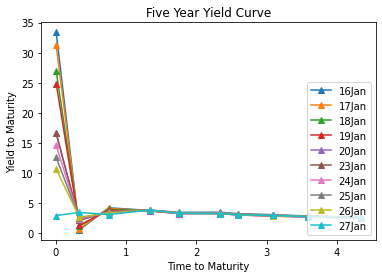

In [48]:
plt.xlabel('Time to Maturity')
plt.ylabel('Yield to Maturity')
plt.title('Five Year Yield Curve')
for i in range(TOTAL_DAYS):
    yr = all_ytms[i]
    curve_label = bond_dates[i]
    plot(tr, array(yr)*100, marker='^', label=curve_label)
legend(loc=4), show();

## Calculating Spot Rate (via Bootstrapping Method):

An underlying assumption for this method would be that all bonds priced at par have coupon rate equal to ytm, we can utilise the following equation to find ith spot rate:

$$
   \frac{C}{(1 + rate)^1}\ + \frac{C}{(1 + rate)^2}\ + \ ... \ + \frac{C}{(1 + rate)^i}\ = \ 100
$$

In [58]:
def get_spot_rates_one_day(ytms_one_day, time_periods):

    res = []  
    for i in range(len(time_periods)): 
        total_sum = 0
        for j in range(0, i): 
            total_sum += ytms_one_day[i] / (1 + res[j]) ** time_periods[j]
        value = ((1 + ytms_one_day[i]) / (1 - total_sum)) ** (1 / t[i]) - 1
        res.append(value)
    return res

def generate_spot_rates_all_days(ytms_all_days, time_periods):
    spot_rates = []
    
    for i in range(len(ytms_all_days)): 
        spot_rates_ith_day = get_spot_rates_one_day(ytms_all_days[i], time_periods)
        print(spot_rates_ith_day)
        spot_rates.append(spot_rates_ith_day)
    
    return spot_rates

all_spot_rates = generate_spot_rates_all_days(all_ytms,t)

[0.333886223483842, 0.0051717489809974815, 0.04038241923400099, 0.03649558793366725, 0.033583052022608806, 0.03397376361138238, 0.031785356892858996, 0.02997623721434306, 0.027770839396160207, 0.025662685896920445]
[0.31227357908112263, 0.006995967343540688, 0.039505041786993544, 0.0361029309903389, 0.032709506974750724, 0.03315917971019933, 0.031130410053217927, 0.029536275636348863, 0.027476905223674963, 0.02553269971283756]
[0.2696301871031763, 0.011025750194887607, 0.038286442212503324, 0.03614688468732341, 0.032557425984682364, 0.032978567314078555, 0.030709654136747755, 0.029232161311840255, 0.027289987892948453, 0.025467363390091036]
[0.24860585802212642, 0.01223464448274414, 0.036916030868616945, 0.03594769417542398, 0.03184883312734743, 0.032219157625539285, 0.029822606238926408, 0.027742260312900058, 0.026382257091171812, 0.024808983691450015]
[0.1664117593761527, 0.02044038690525496, 0.03480767890889758, 0.03703807883463872, 0.03227529641053195, 0.03210189263289842, 0.029901

## Spot Rate Curve for 10 days:

Below is the plot for the 5-year spot rate curve for all 10 days:

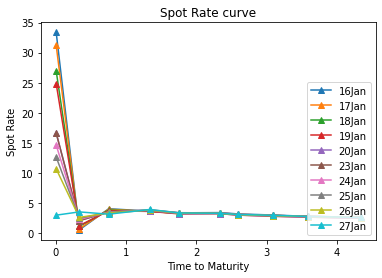

In [59]:
plt.xlabel('Time to Maturity')
plt.ylabel('Spot Rate')
plt.title('Spot Rate curve')

for i in range(TOTAL_DAYS):
    sr = all_spot_rates[i]
    curve_label = bond_dates[i]
    plot(tr, array(sr)*100, marker='^', label=curve_label)
legend(loc=4), show();

## Calculating Forward Rates:

To get the 1-year forward rates with terms ranging from 2-5 years to plot the yield curve, we utilise the following equation to calculate:

 $\mathbf{r_{0n}}$: 0th year - nth year spot rate 

$\mathbf{f_{1n}}$: 1th year - nth year forward rate

From:
$$
e^{r_{01} \cdot 1} \cdot e^{f_{1 t} \cdot(t-1)}=e^{r_{0 t} \cdot t}
$$ 

Forward Rate can be derived through:
$$
f_{1 t}=\frac{r_{0 t} \cdot t-r_{01}}{t-1}
$$ 

In [89]:


def get_forward_rates(spot_rates):
    forward_rates = []
    r = spot_rates[2]
    n = len(spot_rates)
    
    k = 3
    counter = 2
    while (k < n):
        spot_rate = spot_rates[counter]
        forward_rate = float((spot_rate * counter  - r) / (counter - 1))
        forward_rates.append(forward_rate)
        counter += 1
        k += 2
    
    return forward_rates


def generate_forward_rates(all_spot_rates):
    all_forward_rates = []
    for i in range(len(all_spot_rates)):
        fr_one_day = get_forward_rates(all_spot_rates[i])
        all_forward_rates.append(fr_one_day)
        print(fr_one_day)
    
    return all_forward_rates

all_forward_rates = generate_forward_rates(all_spot_rates)

[0.03260875663333351, 0.030769435800073075, 0.026507509874457085, 0.02198275256265031]
[0.032700820193684255, 0.029986248671802218, 0.02621335358613397, 0.022039614194298562]
[0.0340073271621435, 0.03032462986486617, 0.026214067678285897, 0.022262593684487963]
[0.03497935748223102, 0.029870721004000456, 0.02468433679432776, 0.021782221897158283]
[0.039268478760379866, 0.030748999494898843, 0.02602051776062549, 0.022102664805915107]
[0.040317658636380704, 0.03180818275843367, 0.02704464770923587, 0.024009939593693574]
[0.04164301440240403, 0.03257499969207944, 0.02744048771084177, 0.023908243394071882]
[0.04296012007074146, 0.03306542876678542, 0.027708729533703364, 0.024096728784134158]
[0.04287347302402078, 0.03216889546388413, 0.0272910733633569, 0.02382115795681483]
[0.04698833923395118, 0.03361570458810503, 0.028825245928773002, 0.02450891234465019]


In [77]:
# Since 1-year derived forward rate curve
t = [0,1,2,3]

## 1-Year Derived Forward Rates Curve:

Below is the plot for the 1-year forward curve with terms ranging from 2-5 years:

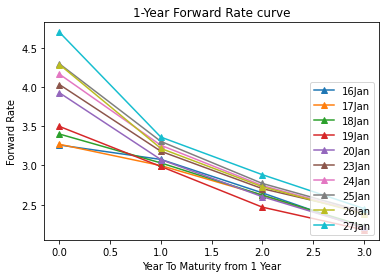

In [85]:
plt.xlabel('Year To Maturity from 1 Year')
plt.ylabel('Forward Rate')
plt.title('1-Year Forward Rate curve')

for i in range(TOTAL_DAYS):
    sr = all_forward_rates[i]
    curve_label = bond_dates[i]
    plot(t, array(sr)*100, marker='^', label=curve_label)
legend(loc=4), show();


## Calculating YTM Covariance:

In [95]:
def get_ytm_covariance(ytms):
    all_ytms = []
    total_ytms = len(ytms)
    total_days = len(ytms[0])
    
    for i in range(total_ytms):
        x, j = [], 1
        
        for k in range(j, total_days, 2):
            x.append(ytms[i][k])
        all_ytms.append(x)
        
      # transpose matrix
    list_of_ytms = np.array(all_ytms).transpose()

    # Instantiate returns matrix
    returns_matrix = np.zeros((5, 9))
    n = len(list_of_ytms)
    
    # Compute the matrix of returns:
    for i in range(n):
        for j in range(n-1):
            returns_matrix[i][j] = math.log(list_of_ytms[i][j]/list_of_ytms[i][j+1])

    
    # Calculate covariance matrix
    covariance_matrix = np.cov(returns_matrix)
    print("[YTM] Covariance Matrix:")
    print(covariance_matrix)
    return covariance_matrix

ytm_returns = get_ytm_covariance(all_ytms)

[YTM] Covariance Matrix:
[[ 4.09192905e-02  2.70383515e-04 -1.12059936e-03 -8.03345173e-05
  -6.13675803e-04]
 [ 2.70383515e-04  6.35431217e-05  4.38337241e-05  1.01632256e-04
   2.08219614e-05]
 [-1.12059936e-03  4.38337241e-05  1.15246011e-04  1.44635657e-04
   8.33109274e-05]
 [-8.03345173e-05  1.01632256e-04  1.44635657e-04  3.24597106e-04
   1.43289552e-04]
 [-6.13675803e-04  2.08219614e-05  8.33109274e-05  1.43289552e-04
   8.81944132e-05]]


In [96]:
ytm_w, ytm_v = LA.eig(ytm_returns)
print("[YTM] Eigenvalues for log-returns:")
print(ytm_w)
print("[YTM] Eigenvectors for log-returns:")
print(ytm_v)

[YTM] Eigenvalues for log-returns:
[ 4.09612652e-02  4.87043212e-04  4.42895867e-05  1.82731722e-05
 -4.62576735e-20]
[YTM] Eigenvectors for log-returns:
[[ 0.99948579  0.01583647 -0.01182234 -0.02520422 -0.00153071]
 [ 0.00656548  0.26170982  0.80096796  0.01640746  0.53818768]
 [-0.02745178  0.37929655  0.08828219 -0.87415915 -0.28884695]
 [-0.00211029  0.81108281 -0.03730711  0.46487983 -0.35303702]
 [-0.01506647  0.35991106 -0.59086799 -0.1372154   0.70871996]]


## Calculating Forward Rate Covariances: 

In [98]:
def get_forward_rate_covariance(frs):
    all_frs = []
    total_frs = len(frs)
    total_days = len(frs[0])
    
    for i in range(total_frs):
        x, j = [], 0
        for k in range(j, total_days):
            x.append(frs[i][k])
        all_frs.append(x)
        
      # transpose matrix
    all_frs = np.array(all_frs).transpose()

    # Instantiate returns matrix
    returns_matrix = np.zeros((4, 9))
    n = len(all_frs)
    
    # Compute the matrix of returns:
    for i in range(n):
        for j in range(n-1):
            returns_matrix[i][j] = math.log(all_frs[i][j]/all_frs[i][j+1])
    
    
    # Calculate covariance matrix
    covariance_matrix = np.cov(returns_matrix)
    print("[1-Year Forward Rate] Covariance Matrix:")
    print(covariance_matrix)
    return covariance_matrix

fr_returns = get_forward_rate_covariance(all_forward_rates)
    

[1-Year Forward Rate] Covariance Matrix:
[[ 2.23715106e-04  2.16286789e-05 -1.46158188e-04 -1.77072808e-05]
 [ 2.16286789e-05  1.15061966e-04  1.20015600e-04  4.31441184e-05]
 [-1.46158188e-04  1.20015600e-04  3.96951339e-04  1.51311161e-04]
 [-1.77072808e-05  4.31441184e-05  1.51311161e-04  7.18141412e-05]]


In [99]:

forward_eigenvalues, forward_eigenvectors = LA.eig(fr_returns)
print("[1-Year Forward Rate] Eigenvalues for log-returns:")
print(forward_eigenvalues)
print("[1-Year Forward Rate] Eigenvectors for log-returns:")
print(forward_eigenvectors)


[1-Year Forward Rate] Eigenvalues for log-returns:
[ 5.51079755e-04  2.05844032e-04 -5.63515763e-21  5.06187660e-05]
[1-Year Forward Rate] Eigenvectors for log-returns:
[[ 0.37610131  0.82705946 -0.27662046  0.31305204]
 [-0.24288953  0.49652402  0.25726773 -0.79264235]
 [-0.84180278  0.14820618 -0.48117212  0.1946186 ]
 [-0.30153038  0.2178795   0.79105488  0.48563374]]
